In [1]:
from load import *
from torch import Tensor, nn
import torch
from model_base import *
from modules import *
from anim import *
import util
import matplotlib.pyplot as plt
from scipy.optimize import minimize

ROOT = "./Datas/Week 8"

Q = 1.60217663e-19

In [2]:
sc = load_space_charge() * -Q
ep = load_elec_potential()
vg = load_vgs()
poi = NormalizedPoissonMSE('cpu')
poi(ep, sc)

tensor(5.3032e-10, dtype=torch.float64)

In [3]:
# This model does not need to be trained
class PoissonJITRegressor(Model):
    """Use a first model to predict stuff, then use a second model to make them self consistent - aka satisfy the Poisson equation"""
    def __init__(self, ep1: TrainedLinear, sc1: TrainedLinear):
        # From the linearity plots, we only need to care about region 2 in practice for space charge
        # and region 2, 5 for electric potential
        self.ep1 = ep1
        self.sc1 = sc1
        
    def forward(self, x):
        num_data = int(x.shape[0])
        # xep = x[:, :2193].reshape(-1, 129, 17)
        # xsc = x[:, 2193:].reshape(-1, 129, 17)

        naive_prediction = torch.cat([self.ep1(x), self.sc1(x)], dim = 1)

        result = torch.zeros(num_data, 4386)
        with torch.no_grad():
            xep = self.ep1(x).cpu().numpy().reshape(-1, 129, 17)
            xsc = self.sc1(x).cpu().numpy().reshape(-1, 129, 17)

            poisson_loss = NormalizedPoissonRMSE('cpu')

            # Nudge region 2, 5 of ep, region 2 of sc
            # Refer to anim.py for region codes
            # The mystery numbers are the number of parameters in different region
            for i in range(num_data):
                def reconstruct(x):
                    ep_region_2 = x[:429].reshape(84 - 45, -1)
                    ep_region_5 = x[429:663].reshape(84 - 45, -1)
                    sc_region_2 = x[663:].reshape(84 - 45, -1)

                    reconstructed_ep = xep[i]
                    reconstructed_ep[45:84,:11] = ep_region_2
                    reconstructed_ep[45:84,11:] = ep_region_5
                    reconstructed_ep = torch.tensor(reconstructed_ep.reshape(1, 129, 17))

                    reconstructed_sc = xsc[i]
                    reconstructed_sc[45:84,:11] = sc_region_2
                    reconstructed_sc = torch.tensor(reconstructed_sc.reshape(1, 129, 17))

                    return reconstructed_ep, reconstructed_sc
                
                def minimize_me(x):
                    reconstructed_ep, reconstructed_sc = reconstruct(x)
                    mse = poisson_loss(reconstructed_ep, reconstructed_sc)
                    return float(mse.item())
                
                ep_region_2 = xep[i,45:84,:11].reshape(-1)
                ep_region_5 = xep[i,45:84,11:].reshape(-1)
                sc_region_2 = xsc[i,45:84,:11].reshape(-1)

                joined = np.concatenate([ep_region_2, ep_region_5, sc_region_2])
                bounds = [(0, 1)] * 663 + [(-20, 20)] * 429
                gradient_descent = minimize(minimize_me, x0 = joined, bounds = bounds)
                grad_result = gradient_descent.x
                new_ep, new_sc = reconstruct(grad_result)
                result[i][:2193] = new_ep.reshape(-1)
                result[i][2193:] = new_sc.reshape(-1)

                print(f"Frame {i}: Difference: {torch.mean(torch.abs(naive_prediction[i] - result[i]))}", end = "")

                poi = poisson_loss(new_ep, new_sc)
                print(f" Poisson loss: {poi}")

        return result

In [4]:
x = vg[:30]
epy = ep[:30]
scy = sc[:30]
ep_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, epy.reshape(-1, 2193))
sc_linear = TrainedLinear(1, 2193, algorithm='linear').fit(x, scy.reshape(-1, 2193))
model = PoissonJITRegressor(ep_linear, sc_linear)
ypred = model(vg)

Frame 0: Difference: 8.392442296667468e-10 Poisson loss: 0.00029653983074240386
Frame 1: Difference: 7.474362795356626e-10 Poisson loss: 0.0003068466030526906
Frame 2: Difference: 6.692951748377141e-10 Poisson loss: 0.00030469990451820195
Frame 3: Difference: 8.76668682092685e-10 Poisson loss: 0.00031088184914551675
Frame 4: Difference: 7.100762755563039e-10 Poisson loss: 0.00030516585684381425
Frame 5: Difference: 8.663714745615891e-10 Poisson loss: 0.000309190945699811
Frame 6: Difference: 5.641247469156951e-10 Poisson loss: 0.0003065404307562858
Frame 7: Difference: 5.43778910788717e-10 Poisson loss: 0.00030361011158674955
Frame 8: Difference: 6.455641576863513e-10 Poisson loss: 0.00030353700276464224
Frame 9: Difference: 5.200215258405194e-10 Poisson loss: 0.0003132055571768433
Frame 10: Difference: 2.6160310029332834e-10 Poisson loss: 0.0003089686797466129
Frame 11: Difference: 2.922078412570528e-10 Poisson loss: 0.00031238346127793193
Frame 12: Difference: 4.3150319428697514e-10 

In [5]:
from anim import make_anim

ypred_ep = ypred[:, :2193].reshape(-1, 129, 17)
ypred_sc = ypred[:, 2193:].reshape(-1, 129, 17)

make_anim(ypred_ep, ep, "ep_jit1.gif", "Electric potential first 30")
make_anim(ypred_sc, sc, "sc_jit1.gif", "Space charge first 30")

c:\Users\Darin\Documents\Repository\physical-simulation-ml-3900\anim.py:423: RuntimeWarning: divide by zero encountered in log10
  err_log_10 = np.log10(error)
c:\Users\Darin\Documents\Repository\physical-simulation-ml-3900\anim.py:423: RuntimeWarning: divide by zero encountered in log10
  err_log_10 = np.log10(error)


Let's investigate a bit on best-fit lines and algorithms to find best fit lines. This can potentially improve the first prediction of poisson plots

In [29]:
import numpy as np
import matplotlib.pyplot as plt

def f(d, m, c):
    ypred = m * d[0] + c
    return np.sqrt(np.mean((d[1] - ypred) ** 2))

def plot_xy(data, modifier):
    # Range
    vmin, vmax = -10, 10

    fig, ax = plt.subplots()
    ax.scatter(data[0], data[1])
    y = data[0] * 2 + 3
    ax.plot(data[0], y, color = 'orange', linewidth = 3)

    # Generate x and y values
    x = np.linspace(vmin, vmax, 200)
    y = np.linspace(vmin, vmax, 200)

    # Create empty array for Z values
    Z = np.empty((len(x), len(y)))

    # Calculate the corresponding Z values using the function f
    min_score = 999999
    for i in range(len(x)):
        for j in range(len(y)):
            score = f(data, x[i], y[j])
            min_score = min(score, min_score)
            Z[i, j] = modifier(score)

    # Create the heatmap plot
    plt.figure()
    plt.imshow(Z, cmap='hot', extent=[vmin, vmax, vmin, vmax], origin='lower')
    plt.colorbar()

    # Set plot title and labels
    plt.title("Heatmap Plot of f(x, y)")
    plt.xlabel("m")
    plt.ylabel("c")

    print(f"Minimized value: {min_score}, min modified: {np.min(Z)}")

Minimized value: 0.1019865311398961, min modified: -0.9914571795896296


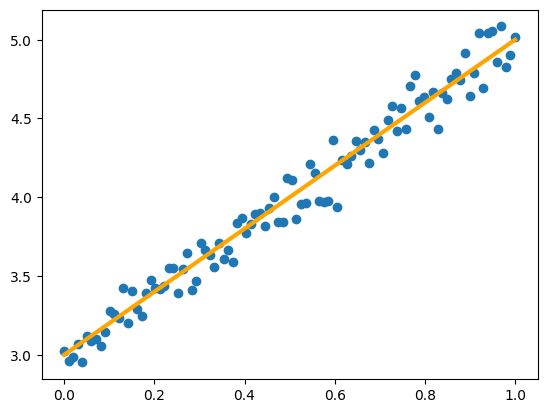

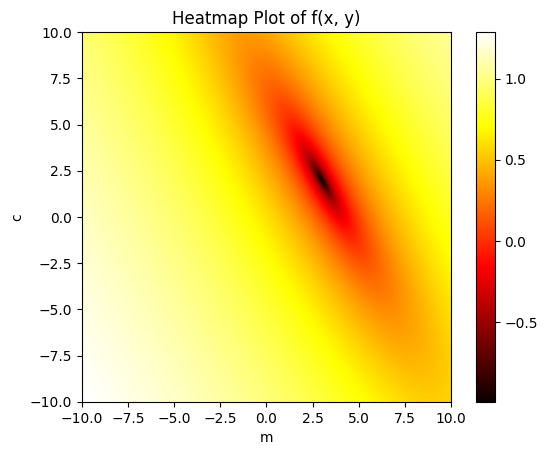

In [30]:
data = np.zeros((2, 100))
data[0] = np.linspace(0, 1, 100)
data[1] = data[0] * 2 + 3 + np.random.normal(size = (100,)) * 0.1
plot_xy(data, lambda x: np.log10(1e-20 + x))

Minimized value: 0.134398369291133, min modified: -0.8716060007179004


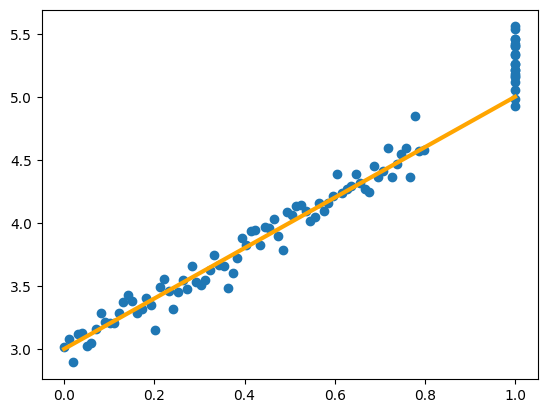

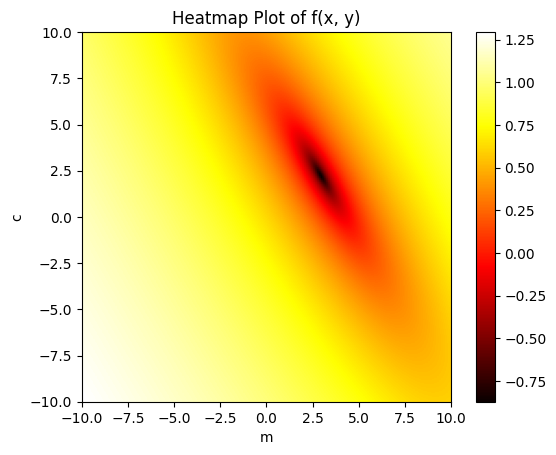

In [34]:
data = np.zeros((2, 100))
data[0] = np.linspace(0, 1, 100)
data[1] = data[0] * 2 + 3 + np.random.normal(size = (100,)) * 0.1
data[0][-20:] = 1
data[1][-20:] += 0.5
plot_xy(data, lambda x: np.log10(1e-20 + x))